In [2]:
import pandas as pd
import numpy as np
import math
from collections import defaultdict
import ts_code.nsfg as nsfg
import ts_code.thinkstats2 as thinkstats2
import ts_code.thinkplot as thinkplot
import ts_code.first as first
import matplotlib.pyplot as plt
import ts_code.brfss as brfss
import statsmodels.formula.api as smf
%matplotlib inline

## Chapter 13 Survival analysis

**Survival analysis** describes how long things last.

The fundamental concept is the **survival curve**, $S(t)$, which is a function of duration, $(t)$, and maps this duration to the probability of surviving longer than $t$.

If you know the distribution of durations, the survival curve can be derived as the completement of the CDF.

$$S(t) = 1 - CDF(t)$$

where $CDF(t)$ is the probability of a lifetime $<= t$.

Using the NSFG dataset, we have information of the duration of pregnencies.

In [3]:
preg = nsfg.ReadFemPreg()
complete = preg.query('outcome in [1,3,4]').prglngth #(live birth, still birth, miscarriage)
#$query takes a boolean expression and evaluates it for each row, selecting the rows that yield True.
cdf = thinkstats2.Cdf(complete, label = 'cdf')

In [4]:
type(cdf.xs)
type((1-cdf.ps))

numpy.ndarray

In [5]:
def MakeSurvivalCurve(series):
    cdf = thinkstats2.Cdf(complete, label = 'cdf')
    sf = pd.Series(1-cdf.ps, index=cdf.xs)
    return sf

In [6]:
sf = MakeSurvivalCurve(complete)

In [7]:
survival_curve = 1 - cdf.ps

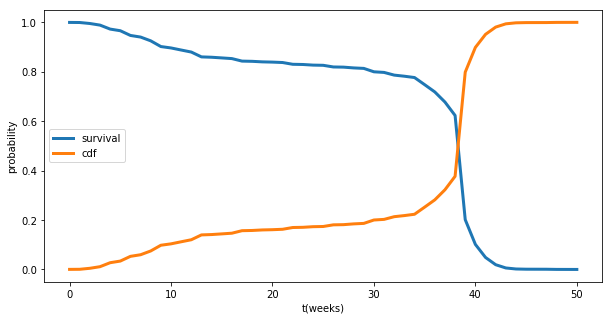

In [8]:
plt.figure(figsize=(10,5))
plt.plot(sf.index, sf.values, lw=3, label = 'survival')
plt.plot(cdf.xs, cdf.ps, lw=3, label = 'cdf')

plt.xlabel('t(weeks)')
plt.ylabel('probability')
plt.legend(loc='center left');

From the survival curve we can derive the **hazard function** which maps from a time $t$ to the fraction of events that continue until $t$ and then end at $t$.

$$\lambda(t) = \frac{S(t)-S(t+1)}{S(t)} = \frac{PMF(t)}{S(t)}$$


Using the hazard function with the pregnency data, of *all* pregnancies that process until week 39 about 50% end in week 39.

In many real world scenarios, the distribution of lifetimes cannot be meausre directly. Instead the we need to infer the CDF.

In the NSFG data we can infer the survival curve for how long respondents "survive" until they get married. 

We know the age of marriage for *some* women in the dataset, so it is tempting to exclude the others and compute the CDF on the known data. This is a bad idea for two reasons;

1) older women would be overrepresented because they are more likely to be married at the time of the interview.

2) married women would be overrepresented, this analysis would lead to the conclusion that **all** women get married.

To solve this problem we will use an algorithm called the **Kaplan-Meier estimation**. Essentially we estimate the hazard function and then convert it to the survival curve.

To estimate the hazard function for our married women question, consider for each age;

1) The number of women who got married at that age

2) the number of women "at risk" of getting married, which includes all women who were not married at an earlier age.

In [18]:
def EstimateHazard(complete, ongoing):
    
    hist_complete = thinkstats2.Counter(complete)
    hist_ongoing = thinkstats2.Counter(ongoing)
    
    ts = list(hist_complete | hist_ongoing)
    ts.sort()
    
    at_risk = len(complete) + len(ongoing) #everyone is at risk of getting married before we start
    
    lams = pd.Series(index=ts)
    
    for age in ts:
        ended = hist_complete[age]
        unknown = hist_ongoing[age]
        lams[age] = ended/ at_risk #percent of all responded who reach this age and then get married
        at_risk -= ended + unknown
    
    return lams

In [10]:
resp = nsfg.ReadFemResp()

In [11]:
#replace invalid values of cmmarrhx
resp.cmmarrhx.replace([9997, 9998, 9999], np.nan, inplace=True)

In [12]:
#compute respondent's age when married and when interviewed
resp['agemarry'] = (resp.cmmarrhx - resp.cmbirth) / 12.0
resp['age'] = (resp.cmintvw - resp.cmbirth) / 12.0

In [13]:
#find married and not married groups
married = resp[resp.evrmarry==1].agemarry.dropna()
not_married = resp[resp.evrmarry==0].age.dropna()

In [14]:
hf = EstimateHazard(married, not_married)

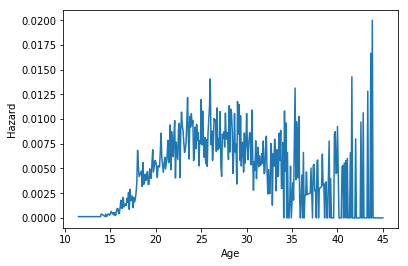

In [15]:
plt.plot(hf.index, hf.values)
plt.xlabel('Age')
plt.ylabel('Hazard');

Once we have the hazard function we can estiamte the survival curve. The chance of surviving past $t$ is the change of suriviving all times up through $t$, which is the cumulative product of the complementary hazard function:

$$[1-\lambda(0)][1-\lambda(1)]\dots[1-\lambda(t)]$$

In [17]:
def MakeSurvival(hf):
    ages = hf.index
    probs = (1-hf).cumprod()
    sf = pd.Series(probs, index=ages)
    return sf

In [17]:
sf = MakeSurvival(hf)

In [18]:
def plotsf(sf, label=''):
    plt.plot(sf.index, sf.values, label=label, lw=3)
    plt.ylim(0, 1)
    plt.xlabel('Age')
    plt.ylabel('Prob Unmarried')
    plt.legend() if label != '' else None

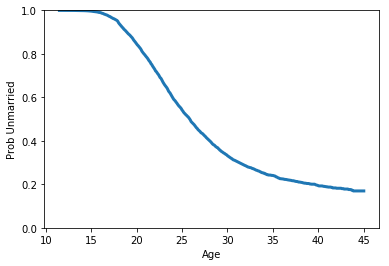

In [19]:
plotsf(sf)

In [16]:
def EstimateSurvival(complete, ongoing):
    hf = EstimateHazard(complete, ongoing)
    sf = MakeSurvival(hf)
    return hf, sf

One of the challenges of survival analysis is that different parts of the estimated curve are based on different groups of respondents.

The part of the curve at time $t$ is based on respondents whose age was at least $t$ when they were interviewed. So the left most part of the curve includes data from all respondents, but the right most part includes only the oldest respondents.

If the relevant measurement/characteristic is not changing over time, this would be okay, but in our case it seems likely that marriage patterns are different for women of differed generations.

We can investigate this by grouping by decade of birth. These groups are called **cohorts** and the difference between them are called **cohort effects**

In [6]:
import ts_code.survival as sur

In [7]:
resp5 = sur.ReadFemResp1995()
resp6 = sur.ReadFemResp2002()
resp7 = sur.ReadFemResp2010()

In [8]:
resps = [resp5, resp6, resp7]

In [24]:
for resp in resps:
    month0 = pd.to_datetime('1899-12-15') #cmbirth is int number of months since Dec 1899
    dates = [month0 + pd.DateOffset(months=cm) for cm in resp.cmbirth] #offset from month 0 the number of months
    resp['decade'] = (pd.DatetimeIndex(dates).year - 1900) // 10 #get year of each offset date, subtract 1900 and floor divide by 10 for decade

In [25]:
def EstimateSurvivalByDecade(groups):
    for name, group in groups:
        name = str(name*10) + 's'
        complete = group[group.evrmarry==1].agemarry.dropna()
        on_going = group[group.evrmarry==0].age.dropna()
        hf, sf = EstimateSurvival(complete, on_going)
        plotsf(sf, label=name)

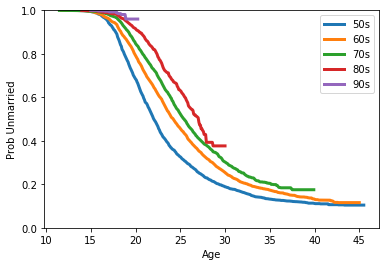

In [26]:
samples = [thinkstats2.ResampleRowsWeighted(resp)for resp in resps]
sample = pd.concat(samples, ignore_index=True)
groups = sample.groupby('decade')
EstimateSurvivalByDecade(groups)

We can extrapolate these curves by "borrowing" data from the previous cohort. 

In [27]:
def Extend(series, other):
    last = series.index[-1]
    more = other[other.index > last]
    series = pd.concat([series, more])
    return series

In [28]:
def PlotPredictionsbyGroup(groups):
    hfs = {}
    for name, group in groups:
        name = str(name*10) + 's'
        complete = group[group.evrmarry==1].agemarry.dropna()
        on_going = group[group.evrmarry==0].age.dropna()
        hf, sf = EstimateSurvival(complete, on_going)
        hfs[name] = hf
    for name, hf in hfs.items():
        if name != '50s':
            hf = Extend(hf, hfs[str(int(name[:-1]) - 10)+'s'])
            hfs[name] = hf
        sf = MakeSurvival(hf)
        plotsf(sf, label = name)

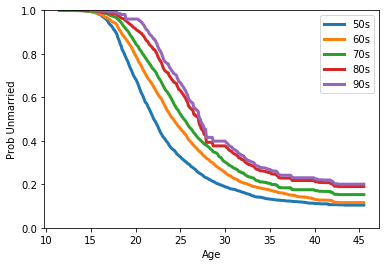

In [29]:
PlotPredictionsbyGroup(groups)

We can compute the expected remaining lifetime as a function of current age by first extracting the PMF of lifetime.

In [30]:
def MakeSurvPMF(series, filler=None):
    sf = MakeSurvivalCurve(series)
    pmf = thinkstats2.Pmf()
    for val, prob in sf.items():
        pmf.Set(val, prob)
    
    cutoff = sf.values[-1]
    if filler is not None:
        pmf[filler] = 1-cutoff
    return pmf

*cutoff* is the highest probability in the Cdf, which is 1 if the Cdf is complete,and otherwise less than 1.

If the Cdf is incomplete, we plug in the provided value, "filler", to cap it off.

The next step is to compute the expected remaining lifetime, where "expected" means average.

In [31]:
def RemainingLifetime(series, filler=None, func = thinkstats2.Pmf.Mean):
    pmf=MakeSruvPMF(series, filler)
    d = {}
    for t in sorted(pmf.Values())[:-1]:
        pmf[t] = 0
        pmf.Normalize()
        d[t] = func(pmf) - t #expected remaing life

The loop iterates through the values in the Pmf. For each value of $t$ it computes the conditional distribution of lifetimes, given that the lifetime exceeds $$. It does that by removing values from the Pmf one at a time and renormalizing the remaining values.

Then it uses func to summarize the conditional distribution. 

### Exercises

**Exercise 13.1** In NSFG Cycles 6 and 7, the variable *cmdivorcx* contains the date of divorce for the respondent's first marriage, if applicable, encoded in century-months.

Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing.

Estimate the hazard and survival curve for the duration of marriage.

Use resampling to take into account sampling weights, and plot data from several resamples to visualize sampling error.

Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.

In [9]:
from datetime import timedelta

In [10]:
resps = [resp6, resp7]

In [11]:
for resp in resps:
    month0 = pd.to_datetime('1899-12-15') 
    dates = [month0 + pd.DateOffset(months=cm) for cm in resp.cmbirth] 
    resp['decade'] = (pd.DatetimeIndex(dates).year - 1900) // 10
    resp['agemarry'] = (resp.cmmarrhx - resp.cmbirth) / 12.0
    resp['agemarry'] = resp['agemarry'] // 10

In [12]:
def build_divorce_data(resp):

    married = resp[resp.evrmarry==1]
    married = married[married.cmmarrhx.notnull()]

    married.cmdivorcx.fillna(0, inplace=True)

    married['cmmarrhx'] = married.cmmarrhx.astype(int)
    married['cmdivorcx'] = married.cmdivorcx.astype(int)
    married['cmintvw'] = married.cmintvw.astype(int)

    married.cmdivorcx.replace([9997, 9998, 9999], 0, inplace=True)

    month0 = pd.to_datetime('1899-12-15')

    married['marriage_dates'] = np.array([month0 + pd.DateOffset(months=cm) for cm in married.cmmarrhx])
    married['interview_dates'] = np.array([month0 + pd.DateOffset(months=cm) for cm in married.cmintvw])
    married['divorce_dates'] = np.array([month0 + pd.DateOffset(months=cm) for cm in married.cmdivorcx])

    married['length_no_divorce'] = married['interview_dates'] - married['marriage_dates']
    married['length_divorce'] = married['divorce_dates'] - married['marriage_dates']
    
    return married

In [13]:
resp6_married = build_divorce_data(resp6)
resp7_married = build_divorce_data(resp7)

In [175]:
not_divorced6 = resp6_married[resp6_married.cmdivorcx == 0].length_no_divorce
divorced6 = resp6_married[(resp6_married.cmdivorcx > 0) & (resp6_married.length_divorce > timedelta(0))].length_divorce

not_divorced7 = resp7_married[resp7_married.cmdivorcx == 0].length_no_divorce
divorced7 = resp7_married[(resp7_married.cmdivorcx > 0) & (resp7_married.length_divorce > timedelta(0))].length_divorce

hf6, sf6 = EstimateSurvival(divorced6, not_divorced6)

hf7, sf7 = EstimateSurvival(divorced7, not_divorced7)

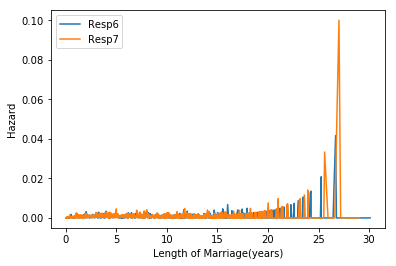

In [176]:
plt.plot(hf6.index.days/365, hf6.values, label='Resp6')
plt.plot(hf7.index.days/365, hf7.values, label='Resp7')

plt.xlabel('Length of Marriage(years)')
plt.ylabel('Hazard')

plt.legend();

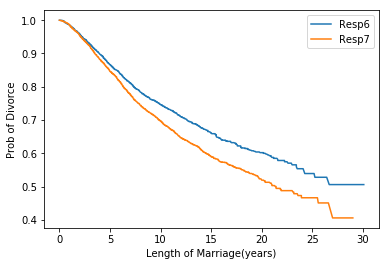

In [178]:
plt.plot(sf6.index.days/365, sf6.values, label='Resp6')
plt.plot(sf7.index.days/365, sf7.values, label='Resp7')

plt.xlabel('Length of Marriage(years)')
plt.ylabel('Prob Not Divorced')

plt.legend();

In [197]:
resp_comb = resp6_married.append(resp7_married)

In [198]:
not_divorced = resp_comb[resp_comb.cmdivorcx == 0].length_no_divorce
divorced = resp_comb[(resp_comb.cmdivorcx > 0) & (resp_comb.length_divorce > timedelta(0))].length_divorce

hf, sf = EstimateSurvival(divorced, not_divorced)

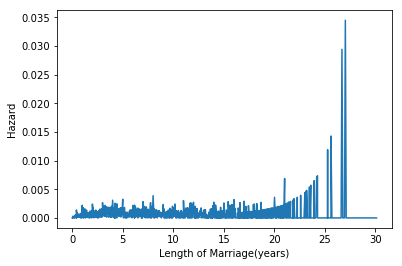

In [199]:
plt.plot(hf.index.days/365, hf.values)

plt.xlabel('Length of Marriage(years)')
plt.ylabel('Hazard');

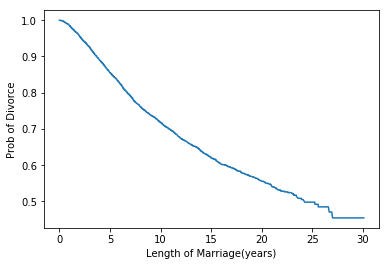

In [200]:
plt.plot(sf.index.days/365, sf.values)

plt.xlabel('Length of Marriage(years)')
plt.ylabel('Prob Not Divorced');

In [193]:
hfs = []
sfs = []
for i in range(100):

    samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
    sample = pd.concat(samples, ignore_index=True)

    sample_married = build_divorce_data(sample)


    not_divorced = sample_married[sample_married.cmdivorcx == 0].length_no_divorce
    divorced = sample_married[(sample_married.cmdivorcx > 0) & (sample_married.length_divorce > timedelta(0))].length_divorce

    hf, sf = EstimateSurvival(divorced, not_divorced)

    hfs.append(hf)
    sfs.append(sf)

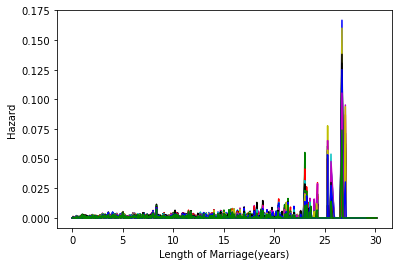

In [194]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
color = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
i = 0
for hf in hfs:
    ax1.plot(hf.index.days/365, hf.values, color=color[i])
    if i < 6:
        i += 1
    else:
        i = 0
                
    
ax1.set_xlabel('Length of Marriage(years)')
ax1.set_ylabel('Hazard')

plt.show();

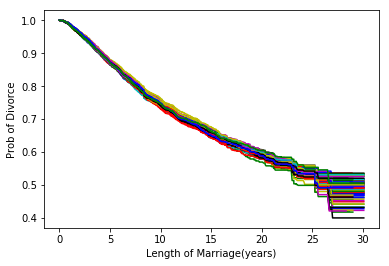

In [195]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
color = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
i = 0
for sf in sfs:
    ax1.plot(sf.index.days/365, sf.values, color=color[i])
    if i < 6:
        i += 1
    else:
        i = 0
                
    
ax1.set_xlabel('Length of Marriage(years)')
ax1.set_ylabel('Prob Not Divorced')

plt.show();

In [28]:
def EstimateSurvivalByDecade_D(groups, born=True):
    ages = {1.0:'teens', 2.0:'20s', 3.0:'30s', 4.0:'40s'}
    for name, group in groups:
        if born:
            name = str(name*10) + 's'
        else:
            name = ages[name]
        not_divorced = group[group.cmdivorcx == 0].length_no_divorce
        divorced = group[(group.cmdivorcx > 0) & (group.length_divorce > timedelta(0))].length_divorce

        hf, sf = EstimateSurvival(divorced, not_divorced)
        
        plt.plot(sf.index.days/365, sf.values, label=name)

        plt.xlabel('Length of Marriage(years)')
        plt.ylabel('Prob of Non-Divorced')
        plt.legend();

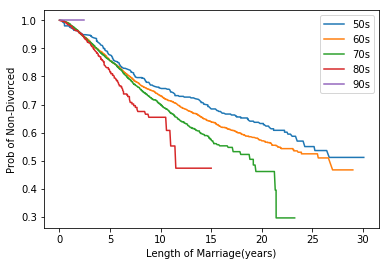

In [37]:
resp6_married = build_divorce_data(resp6)
resp7_married = build_divorce_data(resp7)

resp_comb = resp6_married.append(resp7_married)

not_divorced = resp_comb[resp_comb.cmdivorcx == 0].length_no_divorce
divorced = resp_comb[(resp_comb.cmdivorcx > 0) & (resp_comb.length_divorce > timedelta(0))].length_divorce

groupsD = resp_comb.groupby('decade')
EstimateSurvivalByDecade_D(groupsD)

In [40]:
resp_comb[resp_comb.decade==9.0]

,age,agemarry,caseid,cmbirth,cmdivorcx,cmintvw,cmmarrhx,decade,divorce_dates,evrmarry,finalwgt,fives,interview_dates,length_divorce,length_no_divorce,marriage_dates,parity,wgtq1q16,year
2720,17.083333,1.0,28693,1093,0,1298,1293,9,1899-12-15,True,1777.000784,18,2008-02-15,-39355 days,153 days,2007-09-15,1,1777.000784,91
4189,17.250000,1.0,35461,1108,0,1315,1312,9,1899-12-15,True,1286.022804,18,2009-07-15,-39933 days,91 days,2009-04-15,0,1286.022804,92
4367,18.500000,1.0,38746,1097,0,1319,1313,9,1899-12-15,True,2214.420940,18,2009-11-15,-39963 days,184 days,2009-05-15,1,2214.420940,91
4410,17.750000,1.0,36382,1106,0,1319,1290,9,1899-12-15,True,1764.672964,18,2009-11-15,-39263 days,884 days,2007-06-15,0,1764.672964,92
5849,19.250000,1.0,37206,1088,0,1319,1315,9,1899-12-15,True,11649.535253,18,2009-11-15,-40024 days,123 days,2009-07-15,1,11649.535253,90
7429,19.416667,1.0,39505,1084,0,1317,1299,9,1899-12-15,True,6998.051152,18,2009-09-15,-39537 days,549 days,2008-03-15,2,6998.051152,90
7652,17.250000,1.0,29491,1101,0,1308,1306,9,1899-12-15,True,3482.878444,18,2008-12-15,-39751 days,61 days,2008-10-15,0,3482.878444,91
8286,18.500000,1.0,39691,1089,0,1311,1310,9,1899-12-15,True,3437.167264,18,2009-03-15,-39874 days,28 days,2009-02-15,0,3437.167264,90
9754,18.750000,1.0,34571,1088,0,1313,1287,9,1899-12-15,True,2073.456431,18,2009-05-15,-39171 days,792 days,2007-03-15,1,2073.456431,90
10680,18.666667,1.0,36803,1089,0,1313,1306,9,1899-12-15,True,3895.889638,18,2009-05-15,-39751 days,212 days,2008-10-15,1,3895.889638,90


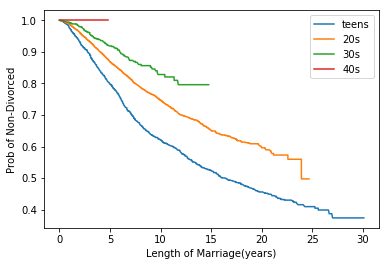

In [38]:
groupsA = resp_comb.groupby('agemarry')
EstimateSurvivalByDecade_D(groupsA,born=False)

In [36]:
resp_comb[resp_comb.agemarry==4.0]

,age,agemarry,caseid,cmbirth,cmdivorcx,cmintvw,cmmarrhx,decade,divorce_dates,evrmarry,finalwgt,fives,interview_dates,length_divorce,length_no_divorce,marriage_dates,parity,wgtq1q16,year
574,44.583333,4.0,745,698,0,1233,1209,5,1899-12-15,True,2736.767233,11,2002-09-15,-36799 days,730 days,2000-09-15,5,NaN,58
1214,43.166667,4.0,12186,712,0,1230,1199,5,1899-12-15,True,4426.448799,11,2002-06-15,-36494 days,943 days,1999-11-15,3,NaN,59
1656,41.666667,4.0,6827,729,0,1229,1226,6,1899-12-15,True,1548.899492,12,2002-05-15,-37317 days,89 days,2002-02-15,2,NaN,60
1693,41.833333,4.0,4903,736,0,1238,1229,6,1899-12-15,True,17124.218238,12,2003-02-15,-37406 days,276 days,2002-05-15,0,NaN,61
1899,41.416667,4.0,10688,741,0,1238,1221,6,1899-12-15,True,17215.531208,12,2003-02-15,-37164 days,518 days,2001-09-15,1,NaN,61
2557,44.416667,4.0,92,702,0,1235,1182,5,1899-12-15,True,3352.339049,11,2002-11-15,-35976 days,1614 days,1998-06-15,3,NaN,58
3245,43.250000,4.0,2655,713,0,1232,1194,5,1899-12-15,True,3515.313920,11,2002-08-15,-36341 days,1157 days,1999-06-15,1,NaN,59
3984,44.250000,4.0,5979,703,0,1234,1223,5,1899-12-15,True,5254.639328,11,2002-10-15,-37225 days,334 days,2001-11-15,0,NaN,58
4168,44.833333,4.0,2110,697,0,1235,1211,5,1899-12-15,True,1583.756996,11,2002-11-15,-36860 days,730 days,2000-11-15,1,NaN,58
4676,43.583333,4.0,8017,705,0,1228,1209,5,1899-12-15,True,3589.095790,11,2002-04-15,-36799 days,577 days,2000-09-15,0,NaN,58


### Glossary

**survival analysis:** A set of methods for describing and predicting lifetimes, or more generally time until an event occurs.

**survival curve:** A function that maps from a time, t, to the probability of surviving past $t$.

**hazard function:** A function that maps from $t$ to the fraction of people alive until $t$ who die at $t$.

**Kaplan-Meier estimation*:** An algorithm for estimating hazard and survival functions.

**cohort:** a group of subjects defined by an event, like date of birth, in a particular interval of time.

**cohort effect:** a difference between cohorts.

**NBUE:** A property of expected remaining lifetime, "New better than used in expectation."

**UBNE:** A property of expected remaining lifetime, "Used better than new in expectation."